# **Proceso de Preparación y EDA PriceHouse**

**Autor** : Oscar Andres Gaspar Alvarez


**Tabla de Contenido**

* 1) Librerias
* 2) Importación Datos
* 3) Depuración de Datos
* 4) Pipeline Imputación y Estandarización de Variables
* 5) Análisis Univariado del Target 
* 6) Análisis de Correlación entre Features
* 7) Selección de Features

# **Filtro de Fechasy Operacion a Realizar**

In [1]:
Operacion="Test"
Temporada=2023
Liga="Brasil B"

In [2]:
FechaInicialTest="2023-11-14"
FechaFinalTest="2023-11-27"

# **1) Librerias** 

In [3]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import datetime as datetime
from itertools import islice
import unidecode
# Gráficos
# ==============================================================================
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')


# Modelado
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline  import Pipeline 
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
import pickle as pk
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

import pycaret
from pycaret.regression import *
import imblearn
import catboost
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import lightgbm as lgb
import shap
import xgboost as xgb
import pickle

import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split # Dividir la data en entraniemo y prueba

# Funciones 
import utils
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')
pd.set_option("display.float_format", lambda x: '%.3f' % x)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 100)

# **2) Importación Datos**

In [4]:
df = pd.read_csv("Insumos/Brazil_B.csv", index_col=0)
df.shape

(3040, 24)

In [5]:
df = df[df['result'].notnull()]

In [6]:
df.shape

(2602, 24)

In [7]:
(df.date.min(),df.date.max())

('2020-08-07', '2023-07-13')

### **Datos Recientes**

In [8]:
df1 = pd.read_csv("Insumos/Brazil_B_Actualidad.csv", index_col=0)

In [9]:
(df1.date.min(),df1.date.max())

('2023-04-14', '2023-11-25')

In [10]:
df_total=pd.concat([df,df1]).reset_index(drop=True)
df_total["Llave"]=df_total.date.astype(str)+df_total.team+df_total.opponent
df_total=df_total.drop_duplicates(['Llave'])

In [11]:
duplicados = df_total[df_total.duplicated(['Llave'])]
duplicados

,date,time,comp,round,day,venue,result,gf,ga,opponent,poss,attendance,captain,formation,referee,match report,notes,sh,sot,dist,pk,pkatt,season,team,Llave


In [12]:
df=df_total.sort_values("date")

## **Excluimos Partidos Pospuestos**

In [13]:
df.attendance=df.attendance
print(df["notes"].unique())

[nan]


In [14]:
df=df[df.notes != "Match Postponed"].reset_index(drop=True)

## **Formato Date a Fecha del Partido**

In [15]:
df['date']=pd.to_datetime(df['date'], format='%Y/%m/%d')

## **Definicion del Target**

In [16]:
df.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,poss,attendance,captain,formation,referee,match report,notes,sh,sot,dist,pk,pkatt,season,team,Llave
0,2020-08-07,18:15,Série B,Matchweek 1,Fri,Away,D,0.000,0.000,Cuiabá,32.000,NaN,Leandro Leite,3-5-2,Jonathan Antero Silva,Match Report,NaN,4.000,3.000,NaN,0.000,0.000,2020,Brasil de Pelotas,2020-08-07Brasil de PelotasCuiabá
1,2020-08-07,22:30,Série B,Matchweek 1,Fri,Away,D,2.000,2.000,Confiança,34.000,NaN,Fabrício,4-2-3-1,Luiz Paulo de Moura Pinheiro,Match Report,NaN,7.000,2.000,NaN,0.000,0.000,2020,Parana,2020-08-07ParanaConfiança
2,2020-08-07,22:30,Série B,Matchweek 1,Fri,Home,D,2.000,2.000,Paraná,66.000,NaN,Amaral,4-1-4-1,Luiz Paulo de Moura Pinheiro,Match Report,NaN,24.000,10.000,NaN,0.000,0.000,2020,Confianca,2020-08-07ConfiancaParaná
3,2020-08-07,18:15,Série B,Matchweek 1,Fri,Home,D,0.000,0.000,Brasil de Pelotas,68.000,NaN,Anderson Conceição,4-2-3-1,Jonathan Antero Silva,Match Report,NaN,19.000,6.000,NaN,0.000,0.000,2020,Cuiaba,2020-08-07CuiabaBrasil de Pelotas
4,2020-08-08,19:00,Série B,Matchweek 1,Sat,Away,L,0.000,1.000,Vitória,42.000,NaN,Paulo Sérgio,4-4-2,Antonio Dib Moraes de Sousa,Match Report,NaN,13.000,5.000,NaN,0.000,0.000,2020,Sampaio Correa,2020-08-08Sampaio CorreaVitória


In [17]:
df.result.value_counts(normalize=True)

L   0.350
W   0.350
D   0.300
Name: result, dtype: float64

In [18]:
#df['target'] = (df['gf'] > 0) & (df['ga'] > 0)
#df['target'] = df['target'].astype(int)

In [19]:
#df.head()

In [20]:
def assign_target(result):
    if result == 'W' or result == 'D':
        return 1
    elif result == 'L':
        return 0


# Aplicar la función personalizada a la columna 'result' y crear una nueva columna 'target'
df['target'] = df['result'].apply(assign_target)

df.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,poss,attendance,captain,formation,referee,match report,notes,sh,sot,dist,pk,pkatt,season,team,Llave,target
0,2020-08-07,18:15,Série B,Matchweek 1,Fri,Away,D,0.000,0.000,Cuiabá,32.000,NaN,Leandro Leite,3-5-2,Jonathan Antero Silva,Match Report,NaN,4.000,3.000,NaN,0.000,0.000,2020,Brasil de Pelotas,2020-08-07Brasil de PelotasCuiabá,1.000
1,2020-08-07,22:30,Série B,Matchweek 1,Fri,Away,D,2.000,2.000,Confiança,34.000,NaN,Fabrício,4-2-3-1,Luiz Paulo de Moura Pinheiro,Match Report,NaN,7.000,2.000,NaN,0.000,0.000,2020,Parana,2020-08-07ParanaConfiança,1.000
2,2020-08-07,22:30,Série B,Matchweek 1,Fri,Home,D,2.000,2.000,Paraná,66.000,NaN,Amaral,4-1-4-1,Luiz Paulo de Moura Pinheiro,Match Report,NaN,24.000,10.000,NaN,0.000,0.000,2020,Confianca,2020-08-07ConfiancaParaná,1.000
3,2020-08-07,18:15,Série B,Matchweek 1,Fri,Home,D,0.000,0.000,Brasil de Pelotas,68.000,NaN,Anderson Conceição,4-2-3-1,Jonathan Antero Silva,Match Report,NaN,19.000,6.000,NaN,0.000,0.000,2020,Cuiaba,2020-08-07CuiabaBrasil de Pelotas,1.000
4,2020-08-08,19:00,Série B,Matchweek 1,Sat,Away,L,0.000,1.000,Vitória,42.000,NaN,Paulo Sérgio,4-4-2,Antonio Dib Moraes de Sousa,Match Report,NaN,13.000,5.000,NaN,0.000,0.000,2020,Sampaio Correa,2020-08-08Sampaio CorreaVitória,0.000


In [21]:
df.target.value_counts()

1.000    1963
0.000    1057
Name: target, dtype: int64

In [22]:
df.target.value_counts(normalize=True)

1.000   0.650
0.000   0.350
Name: target, dtype: float64

## **Mes del partido**

In [23]:
## Mes
dw_mapping={
    "01": 'Enero', 
    "02": 'Febrero', 
    "03": 'Marzo', 
    "04": 'Abril', 
    "05": 'Mayo',
    "06": 'Junio', 
    "07": 'Julio',
    "08": "Agosto",
    "09": "Septiembre",
    "10": "Octubre",
    "11":"Noviembre",
    "12": "Noviembre"}
df['Mes']=df['date'].dt.strftime('%m').map(dw_mapping)

In [24]:
df["hour"] = df["time"].str.replace(":.+", "", regex=True).astype("str")
#df["hour"] = df["hour"].astype(int)

In [25]:
df.head(5)

,date,time,comp,round,day,venue,result,gf,ga,opponent,poss,attendance,captain,formation,referee,match report,notes,sh,sot,dist,pk,pkatt,season,team,Llave,target,Mes,hour
0,2020-08-07,18:15,Série B,Matchweek 1,Fri,Away,D,0.000,0.000,Cuiabá,32.000,NaN,Leandro Leite,3-5-2,Jonathan Antero Silva,Match Report,NaN,4.000,3.000,NaN,0.000,0.000,2020,Brasil de Pelotas,2020-08-07Brasil de PelotasCuiabá,1.000,Agosto,18
1,2020-08-07,22:30,Série B,Matchweek 1,Fri,Away,D,2.000,2.000,Confiança,34.000,NaN,Fabrício,4-2-3-1,Luiz Paulo de Moura Pinheiro,Match Report,NaN,7.000,2.000,NaN,0.000,0.000,2020,Parana,2020-08-07ParanaConfiança,1.000,Agosto,22
2,2020-08-07,22:30,Série B,Matchweek 1,Fri,Home,D,2.000,2.000,Paraná,66.000,NaN,Amaral,4-1-4-1,Luiz Paulo de Moura Pinheiro,Match Report,NaN,24.000,10.000,NaN,0.000,0.000,2020,Confianca,2020-08-07ConfiancaParaná,1.000,Agosto,22
3,2020-08-07,18:15,Série B,Matchweek 1,Fri,Home,D,0.000,0.000,Brasil de Pelotas,68.000,NaN,Anderson Conceição,4-2-3-1,Jonathan Antero Silva,Match Report,NaN,19.000,6.000,NaN,0.000,0.000,2020,Cuiaba,2020-08-07CuiabaBrasil de Pelotas,1.000,Agosto,18
4,2020-08-08,19:00,Série B,Matchweek 1,Sat,Away,L,0.000,1.000,Vitória,42.000,NaN,Paulo Sérgio,4-4-2,Antonio Dib Moraes de Sousa,Match Report,NaN,13.000,5.000,NaN,0.000,0.000,2020,Sampaio Correa,2020-08-08Sampaio CorreaVitória,0.000,Agosto,19


## **Diccionario Variables**

Estándar
* Gls -- Goles marcados o concedidos
* Sh -- Disparos Totales No incluye tiros penales
* SoT -- Disparos al arco
* Nota: Los tiros a puerta no incluyen los tiros penales
* SoT% -- Porcentaje de tiros que dan en el blanco
* Mínimo .395 tiros por juego de equipo para calificar como líder
* Nota: Los tiros a puerta no incluyen los tiros penales
* G/Sh -- Goles por tiro
* Mínimo .395 tiros por juego de equipo para calificar como líder
* G/SoT -- Goles por tiro al arco
* Mínimo .111 tiros al arco por juego de equipo para calificar como líder
* Nota: Los tiros a puerta no incluyen los tiros penales
* Dist -- Distancia promedio, en yardas, desde la portería de todos los tiros realizados
* Mínimo .395 tiros por juego de equipo para calificar como líder
No incluye tiros penales
* FK -- Remates de tiros libres
* PK -- Penales anotados
* PKatt -- Intento de tiros penales

# **3) Depuración de Datos**

## **Homologación de Teams**

In [26]:
Teams=pd.DataFrame({"team":list(df.team.unique()),
              "opponent":list(df.opponent.unique())}).sort_values(["team"],ascending = [True])

Teams.to_excel("Insumos/TeamsBrasil_B.xlsx",index=False)

In [27]:
MaestroTeams=pd.read_excel("Insumos/HomologacionTeamsBrasil_B.xlsx")
MaestroTeams

,opponent,Homologacion
0,ABC,ABC
1,América (MG),America MG
2,Atl Goianiense,Atletico Goianiense
3,Avaí,Avai
4,Bahia,Bahia
5,Botafogo (RJ),Botafogo RJ
6,Botafogo (SP),Botafogo SP
7,Brasil de Pelotas,Brasil de Pelotas
8,Brusque Futebol Clube,Brusque Futebol Clube
9,Ceará,Ceara


In [28]:

df=df.merge(MaestroTeams, on='opponent', how='left')

In [29]:
df.opponent=df.Homologacion
df.drop(columns=["Homologacion"],inplace=True)

In [30]:
df.head()

,date,time,comp,round,day,venue,result,gf,ga,opponent,poss,attendance,captain,formation,referee,match report,notes,sh,sot,dist,pk,pkatt,season,team,Llave,target,Mes,hour
0,2020-08-07,18:15,Série B,Matchweek 1,Fri,Away,D,0.000,0.000,Cuiaba,32.000,NaN,Leandro Leite,3-5-2,Jonathan Antero Silva,Match Report,NaN,4.000,3.000,NaN,0.000,0.000,2020,Brasil de Pelotas,2020-08-07Brasil de PelotasCuiabá,1.000,Agosto,18
1,2020-08-07,22:30,Série B,Matchweek 1,Fri,Away,D,2.000,2.000,Confianca,34.000,NaN,Fabrício,4-2-3-1,Luiz Paulo de Moura Pinheiro,Match Report,NaN,7.000,2.000,NaN,0.000,0.000,2020,Parana,2020-08-07ParanaConfiança,1.000,Agosto,22
2,2020-08-07,22:30,Série B,Matchweek 1,Fri,Home,D,2.000,2.000,Parana,66.000,NaN,Amaral,4-1-4-1,Luiz Paulo de Moura Pinheiro,Match Report,NaN,24.000,10.000,NaN,0.000,0.000,2020,Confianca,2020-08-07ConfiancaParaná,1.000,Agosto,22
3,2020-08-07,18:15,Série B,Matchweek 1,Fri,Home,D,0.000,0.000,Brasil de Pelotas,68.000,NaN,Anderson Conceição,4-2-3-1,Jonathan Antero Silva,Match Report,NaN,19.000,6.000,NaN,0.000,0.000,2020,Cuiaba,2020-08-07CuiabaBrasil de Pelotas,1.000,Agosto,18
4,2020-08-08,19:00,Série B,Matchweek 1,Sat,Away,L,0.000,1.000,Vitoria,42.000,NaN,Paulo Sérgio,4-4-2,Antonio Dib Moraes de Sousa,Match Report,NaN,13.000,5.000,NaN,0.000,0.000,2020,Sampaio Correa,2020-08-08Sampaio CorreaVitória,0.000,Agosto,19


## **Elimiación Variables**

In [31]:
VariablesEliminar=["captain","referee","match report"]

In [32]:
df=df.drop(columns=VariablesEliminar)

In [33]:
df.formation.unique()

array(['3-5-2', '4-2-3-1', '4-1-4-1', '4-4-2', '4-3-3', '4-4-1-1',
       '5-3-2', '4-5-1', '3-4-3', '4-4-2◆', '4-3-1-2', '4-3-2-1',
       '3-4-1-2', '4-2-2-2', '5-4-1', '3-5-1-1', nan, '4-1-3-2',
       '3-1-4-2'], dtype=object)

## **Correccion de Variables Formation**

In [34]:
df.formation=df.formation.str.replace('◆', '')

## **3.1 Mapear Variables**

In [35]:
Mapeo1=utils.mapeo_de_variables(df)
Mapeo1

,Variable,Nulos,Tipo Variable,Valores Unicos,Unicos,Porcentaje Nulos
16,dist,3040,float64,0,[],100.000
13,notes,3040,float64,0,[],100.000
11,attendance,1726,float64,640,"[1663.0, 1310.0, 1699.0, 938.0, 358.0, 1391.0,...",56.776
10,poss,26,float64,57,"[32.0, 34.0, 66.0, 68.0, 42.0, 52.0, 72.0, 55....",0.855
12,formation,21,object,17,"[3-5-2, 4-2-3-1, 4-1-4-1, 4-4-2, 4-3-3, 4-4-1-...",0.691
6,result,20,object,3,"[D, L, W]",0.658
7,gf,20,float64,8,"[0.0, 2.0, 1.0, 3.0, 4.0, 5.0, 7.0, 6.0]",0.658
17,pk,20,float64,3,"[0.0, 1.0, 2.0]",0.658
22,target,20,float64,2,"[1.0, 0.0]",0.658
18,pkatt,20,float64,3,"[0.0, 1.0, 2.0]",0.658


## **3.2) Identificación Variables Constantes**

In [36]:
df,constantes=utils.identifica_la_lista_de_variables_constantes_y_las_elimina(df,Mapeo1)

In [37]:
print(f'Cantidad de Variables constantes eliminadas: {len(constantes)} y son : {constantes}')

Cantidad de Variables constantes eliminadas: 3 y son : ['dist', 'notes', 'comp']


In [38]:
print(f'Dimensión Nueva: {df.shape}')

Dimensión Nueva: (3040, 22)


In [39]:
Mapeo1=utils.mapeo_de_variables(df)
Mapeo1

,Variable,Nulos,Tipo Variable,Valores Unicos,Unicos,Porcentaje Nulos
10,attendance,1726,float64,640,"[1663.0, 1310.0, 1699.0, 938.0, 358.0, 1391.0,...",56.776
9,poss,26,float64,57,"[32.0, 34.0, 66.0, 68.0, 42.0, 52.0, 72.0, 55....",0.855
11,formation,21,object,17,"[3-5-2, 4-2-3-1, 4-1-4-1, 4-4-2, 4-3-3, 4-4-1-...",0.691
15,pkatt,20,float64,3,"[0.0, 1.0, 2.0]",0.658
19,target,20,float64,2,"[1.0, 0.0]",0.658
5,result,20,object,3,"[D, L, W]",0.658
6,gf,20,float64,8,"[0.0, 2.0, 1.0, 3.0, 4.0, 5.0, 7.0, 6.0]",0.658
7,ga,20,float64,8,"[0.0, 2.0, 1.0, 3.0, 4.0, 5.0, 7.0, 6.0]",0.658
12,sh,20,float64,34,"[4.0, 7.0, 24.0, 19.0, 13.0, 15.0, 3.0, 9.0, 1...",0.658
13,sot,20,float64,15,"[3.0, 2.0, 10.0, 6.0, 5.0, 4.0, 1.0, 0.0, 7.0,...",0.658


# **Proceso de Imputacion con Machine Learning**

**Imputacion attendance**

In [40]:
Mapeo1

,Variable,Nulos,Tipo Variable,Valores Unicos,Unicos,Porcentaje Nulos
10,attendance,1726,float64,640,"[1663.0, 1310.0, 1699.0, 938.0, 358.0, 1391.0,...",56.776
9,poss,26,float64,57,"[32.0, 34.0, 66.0, 68.0, 42.0, 52.0, 72.0, 55....",0.855
11,formation,21,object,17,"[3-5-2, 4-2-3-1, 4-1-4-1, 4-4-2, 4-3-3, 4-4-1-...",0.691
15,pkatt,20,float64,3,"[0.0, 1.0, 2.0]",0.658
19,target,20,float64,2,"[1.0, 0.0]",0.658
5,result,20,object,3,"[D, L, W]",0.658
6,gf,20,float64,8,"[0.0, 2.0, 1.0, 3.0, 4.0, 5.0, 7.0, 6.0]",0.658
7,ga,20,float64,8,"[0.0, 2.0, 1.0, 3.0, 4.0, 5.0, 7.0, 6.0]",0.658
12,sh,20,float64,34,"[4.0, 7.0, 24.0, 19.0, 13.0, 15.0, 3.0, 9.0, 1...",0.658
13,sot,20,float64,15,"[3.0, 2.0, 10.0, 6.0, 5.0, 4.0, 1.0, 0.0, 7.0,...",0.658


# **New Features**

In [41]:
df=utils.recodificacion_variables(df,Mapeo1,n_cat=2)

In [42]:
numeric_cols,cat_cols=utils.type_cols(df.drop(columns=["result","target","date","time","Llave"]))
print(f'Cantidad de Variables Numericas : {len(numeric_cols)}')
print(f'Cantidad de Variables Categóricas : {len(cat_cols)}') 

Cantidad de Variables Numericas : 9
Cantidad de Variables Categóricas : 8


In [43]:
df[cat_cols].tail(2)

,round,day,venue,opponent,formation,team,Mes,hour
3038,Matchweek 38,Sat,Home,Juventude,NaN,Ceara,Noviembre,17
3039,Matchweek 38,Sat,Home,Vila Nova,NaN,ABC,Noviembre,17


In [44]:
df[numeric_cols].tail(2)

,gf,ga,poss,attendance,sh,sot,pk,pkatt,season
3038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023
3039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023


In [45]:
# Filtrar las filas con nulos en la columna 'A'
df_Nuevos = df.loc[df['result'].isnull()].reset_index(drop=True)
df_Nuevos.shape

(20, 22)

In [46]:
df_Nuevos.head()

,date,time,round,day,venue,result,gf,ga,opponent,poss,attendance,formation,sh,sot,pk,pkatt,season,team,Llave,target,Mes,hour
0,2023-11-25,17:00,Matchweek 38,Sat,Away,NaN,NaN,NaN,Gremio Novorizontino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,Criciuma,2023-11-25CriciumaGrêmio Novorizontino,NaN,Noviembre,17
1,2023-11-25,17:00,Matchweek 38,Sat,Away,NaN,NaN,NaN,Avai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,Ituano,2023-11-25ItuanoAvaí,NaN,Noviembre,17
2,2023-11-25,17:00,Matchweek 38,Sat,Away,NaN,NaN,NaN,Chapecoense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,Vitoria,2023-11-25VitoriaChapecoense,NaN,Noviembre,17
3,2023-11-25,17:00,Matchweek 38,Sat,Home,NaN,NaN,NaN,Mirassol Futebol Clube,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,Tombense Futebol Clube,2023-11-25Tombense Futebol ClubeMirassol Futeb...,NaN,Noviembre,17
4,2023-11-25,17:00,Matchweek 38,Sat,Home,NaN,NaN,NaN,Londrina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023,Botafogo SP,2023-11-25Botafogo SPLondrina,NaN,Noviembre,17


In [47]:
df_Nuevos.date[0]

Timestamp('2023-11-25 00:00:00')

In [48]:
FechaFinalTest

'2023-11-27'

In [49]:
df=df[df["date"]<=FechaFinalTest].reset_index(drop=True)

In [50]:
Mapeo2=utils.mapeo_de_variables(df)
Mapeo2

,Variable,Nulos,Tipo Variable,Valores Unicos,Unicos,Porcentaje Nulos
10,attendance,1726,float64,640,"[1663.0, 1310.0, 1699.0, 938.0, 358.0, 1391.0,...",56.776
9,poss,26,float64,57,"[32.0, 34.0, 66.0, 68.0, 42.0, 52.0, 72.0, 55....",0.855
11,formation,21,category,17,"[3-5-2, 4-2-3-1, 4-1-4-1, 4-4-2, 4-3-3, 4-4-1-...",0.691
15,pkatt,20,float64,3,"[0.0, 1.0, 2.0]",0.658
19,target,20,category,2,"[1.0, 0.0]",0.658
5,result,20,category,3,"[D, L, W]",0.658
6,gf,20,float64,8,"[0.0, 2.0, 1.0, 3.0, 4.0, 5.0, 7.0, 6.0]",0.658
7,ga,20,float64,8,"[0.0, 2.0, 1.0, 3.0, 4.0, 5.0, 7.0, 6.0]",0.658
12,sh,20,float64,34,"[4.0, 7.0, 24.0, 19.0, 13.0, 15.0, 3.0, 9.0, 1...",0.658
13,sot,20,float64,15,"[3.0, 2.0, 10.0, 6.0, 5.0, 4.0, 1.0, 0.0, 7.0,...",0.658


## **Imputación Datos**

In [51]:
df['attendance'].describe()

count    1314.000
mean     8405.411
std     11205.805
min        83.000
25%      1970.000
50%      4011.000
75%      9959.000
max     63608.000
Name: attendance, dtype: float64

In [52]:
df['attendance']=df['attendance']/1000

In [53]:
df['attendance'].describe()

count   1314.000
mean       8.405
std       11.206
min        0.083
25%        1.970
50%        4.011
75%        9.959
max       63.608
Name: attendance, dtype: float64

In [54]:
df_grouped = df.groupby('team').agg({'attendance': 'mean'})
df_grouped["team"]=df_grouped.index
df_grouped.rename(columns={"attendance":"attendance1"},inplace=True)
df_grouped.reset_index(drop=True,inplace=True)

In [55]:
df_grouped.head()

,attendance1,team
0,5.591,ABC
1,NaN,America MG
2,5.665,Atletico Goianiense
3,5.429,Avai
4,20.103,Bahia


In [56]:
df=pd.merge(df, df_grouped, on='team', how='left')

In [57]:
df["attendance"][df['attendance'].isnull()]=df["attendance1"][df['attendance'].isnull()]
#df["dist"][df['dist'].isnull()]=df["dist1"][df['dist'].isnull()]

In [58]:
Mapeo2=utils.mapeo_de_variables(df)
Mapeo2

,Variable,Nulos,Tipo Variable,Valores Unicos,Unicos,Porcentaje Nulos
22,attendance1,190,float64,34,"[3.5878333333333328, 3.0909999999999997, 6.276...",6.250
10,attendance,190,float64,672,"[3.5878333333333328, 3.0909999999999997, 6.276...",6.250
9,poss,26,float64,57,"[32.0, 34.0, 66.0, 68.0, 42.0, 52.0, 72.0, 55....",0.855
11,formation,21,category,17,"[3-5-2, 4-2-3-1, 4-1-4-1, 4-4-2, 4-3-3, 4-4-1-...",0.691
13,sot,20,float64,15,"[3.0, 2.0, 10.0, 6.0, 5.0, 4.0, 1.0, 0.0, 7.0,...",0.658
6,gf,20,float64,8,"[0.0, 2.0, 1.0, 3.0, 4.0, 5.0, 7.0, 6.0]",0.658
7,ga,20,float64,8,"[0.0, 2.0, 1.0, 3.0, 4.0, 5.0, 7.0, 6.0]",0.658
19,target,20,category,2,"[1.0, 0.0]",0.658
12,sh,20,float64,34,"[4.0, 7.0, 24.0, 19.0, 13.0, 15.0, 3.0, 9.0, 1...",0.658
5,result,20,category,3,"[D, L, W]",0.658


## **Promedio de Variables Numericas Últimas Jornadas**

In [59]:
#Variariables=['gf', 'ga', 'xg', 'xga', 'poss', 'attendance', 'sh', 'sot', 'dist']+["date","team"]

In [60]:
# Calcular el promedio de los últimos tres partidos para cada variable
variables = ['gf', 'ga', 'poss', 'attendance', 'sh', 'sot']
ListaEquipos=df.team.unique().tolist()

Total = pd.DataFrame()
for i in range(len(ListaEquipos)):
    Equipo = df[df.team==ListaEquipos[i]].sort_values("date")
    Equipo['puntos'] = Equipo['result'].map({'W': 3, 'D': 1, 'L': 0})
    # Ordenar los datos por fecha de forma ascendente
    Equipo = Equipo.sort_values(by='date', ascending=True)
    Equipo['puntos'].fillna(0, inplace=True)
    Equipo['puntos'] = Equipo['puntos'].astype(int)
    # Calcular la suma acumulativa de los puntos hasta la fecha actual
    Equipo['suma_puntos'] = Equipo['puntos'].cumsum()
    ### Resultados Ultimos 5 partidos
    Equipo["last1"]=Equipo[["result"]].shift(1)
    Equipo["last2"]=Equipo[["result"]].shift(2)
    Equipo["last3"]=Equipo[["result"]].shift(3)
    Equipo["last4"]=Equipo[["result"]].shift(4)
    Equipo["last5"]=Equipo[["result"]].shift(5)
    ### DOnde jugo los ultimos partidos
    Equipo["Local1"]=Equipo[["venue"]].shift(1)
    Equipo["Local2"]=Equipo[["venue"]].shift(2)
    Equipo["Local3"]=Equipo[["venue"]].shift(3)
    Equipo["Local4"]=Equipo[["venue"]].shift(4)
    Equipo["Local5"]=Equipo[["venue"]].shift(5)
    ## Goles eltimos partidos
    Equipo["ga1"]=Equipo[["ga"]].shift(1)
    Equipo["ga2"]=Equipo[["ga"]].shift(2)
    Equipo["ga3"]=Equipo[["ga"]].shift(3)
    Equipo["ga4"]=Equipo[["ga"]].shift(4)
    Equipo["ga5"]=Equipo[["ga"]].shift(5)
    ## Goles encontra eltimos partidos
    Equipo["gf1"]=Equipo[["gf"]].shift(1)
    Equipo["gf2"]=Equipo[["gf"]].shift(2)
    Equipo["gf3"]=Equipo[["gf"]].shift(3)
    Equipo["gf4"]=Equipo[["gf"]].shift(4)
    Equipo["gf5"]=Equipo[["gf"]].shift(5)
    
    
    num_partidos_anteriores = 4
    for variable in variables:
        Equipo[f'{variable}_promedio'] = Equipo[variable].rolling(window=num_partidos_anteriores,min_periods=3).apply(lambda x: x[:-1].mean())
        Equipo[f'{variable}_lag1'] = Equipo[variable].shift(1)
    # Imprimir los resultados
    #Equipo=Equipo[['date', 'team',"result","suma_puntos","last1","last2","last3","last4","last5"] + [f'{variable}_lag1' for variable in variables]+ [f'{variable}_promedio' for variable in variables]]
    Total = pd.concat([Total, Equipo])

In [61]:
Total=Total.reset_index(drop=True)

In [62]:
Total['last1'] = Total['last1'].fillna("SinResultado")
Total['last2'] = Total['last2'].fillna("SinResultado")
Total['last3'] = Total['last3'].fillna("SinResultado")
Total['last4'] = Total['last4'].fillna("SinResultado")
Total['last5'] = Total['last5'].fillna("SinResultado")

Total['Local1'] = Total['Local1'].fillna("SinResultado")
Total['Local2'] = Total['Local1'].fillna("SinResultado")
Total['Local3'] = Total['Local1'].fillna("SinResultado")
Total['Local4'] = Total['Local1'].fillna("SinResultado")
Total['Local5'] = Total['Local1'].fillna("SinResultado")

Equipo["ga1"]=Equipo[["ga"]].fillna(0)
Equipo["ga2"]=Equipo[["ga"]].fillna(0)
Equipo["ga3"]=Equipo[["ga"]].fillna(0)
Equipo["ga4"]=Equipo[["ga"]].fillna(0)
Equipo["ga5"]=Equipo[["ga"]].fillna(0)
    ## Goles encontra eltimos partidos
Equipo["gf1"]=Equipo[["gf"]].fillna(0)
Equipo["gf2"]=Equipo[["gf"]].fillna(0)
Equipo["gf3"]=Equipo[["gf"]].fillna(0)
Equipo["gf4"]=Equipo[["gf"]].fillna(0)
Equipo["gf5"]=Equipo[["gf"]].fillna(0)

In [63]:
Total.tail()

,date,time,round,day,venue,result,gf,ga,opponent,poss,attendance,formation,sh,sot,pk,pkatt,season,team,Llave,target,Mes,hour,attendance1,puntos,suma_puntos,last1,last2,last3,last4,last5,Local1,Local2,Local3,Local4,Local5,ga1,ga2,ga3,ga4,ga5,gf1,gf2,gf3,gf4,gf5,gf_promedio,gf_lag1,ga_promedio,ga_lag1,poss_promedio,poss_lag1,attendance_promedio,attendance_lag1,sh_promedio,sh_lag1,sot_promedio,sot_lag1
3035,2023-10-26,19:00,Matchweek 34,Thu,Home,D,1.000,1.000,Avai,40.000,5.591,4-2-3-1,12.000,8.000,0.000,0.000,2023,ABC,2023-10-26ABCAvaí,1.000,Octubre,19,5.591,1,21,L,L,D,W,L,Away,Away,Away,Away,Away,3.000,2.000,0.000,0.000,2.000,1.000,1.000,0.000,2.000,1.000,0.667,1.000,1.667,3.000,42.667,45.000,5.591,5.591,15.000,10.000,3.667,2.000
3036,2023-11-07,21:30,Matchweek 35,Tue,Away,L,0.000,1.000,Criciuma,51.000,5.591,4-2-3-1,10.000,3.000,0.000,0.000,2023,ABC,2023-11-07ABCCriciúma,0.000,Noviembre,21,5.591,0,21,D,L,L,D,W,Home,Home,Home,Home,Home,1.000,3.000,2.000,0.000,0.000,1.000,1.000,1.000,0.000,2.000,1.000,1.000,2.000,1.000,45.333,40.000,5.591,5.591,13.333,12.000,6.000,8.000
3037,2023-11-14,21:30,Matchweek 36,Tue,Home,D,0.000,0.000,Juventude,66.000,5.591,4-3-3,8.000,3.000,0.000,0.000,2023,ABC,2023-11-14ABCJuventude,1.000,Noviembre,21,5.591,1,22,L,D,L,L,D,Away,Away,Away,Away,Away,1.000,1.000,3.000,2.000,0.000,0.000,1.000,1.000,1.000,0.000,0.667,0.000,1.667,1.000,45.333,51.000,5.591,5.591,10.667,10.000,4.333,3.000
3038,2023-11-19,15:45,Matchweek 37,Sun,Away,W,3.000,2.000,Guarani,28.000,3.089,4-3-3,8.000,4.000,0.000,0.000,2023,ABC,2023-11-19ABCGuarani,1.000,Noviembre,15,5.591,3,25,D,L,D,L,L,Home,Home,Home,Home,Home,0.000,1.000,1.000,3.000,2.000,0.000,0.000,1.000,1.000,1.000,0.333,0.000,0.667,0.000,52.333,66.000,5.591,5.591,10.000,8.000,4.667,3.000
3039,2023-11-25,17:00,Matchweek 38,Sat,Home,NaN,NaN,NaN,Vila Nova,NaN,5.591,NaN,NaN,NaN,NaN,NaN,2023,ABC,2023-11-25ABCVila Nova,NaN,Noviembre,17,5.591,0,25,W,D,L,D,L,Away,Away,Away,Away,Away,2.000,0.000,1.000,1.000,3.000,3.000,0.000,0.000,1.000,1.000,1.000,3.000,1.000,2.000,48.333,28.000,4.757,3.089,8.667,8.000,3.333,4.000


In [64]:
Mapeo1=utils.mapeo_de_variables(Total)
Mapeo1

,Variable,Nulos,Tipo Variable,Valores Unicos,Unicos,Porcentaje Nulos
51,attendance_promedio,258,float64,1374,"[3.5878333333333328, 2.512222222222222, 1.9672...",8.487
52,attendance_lag1,224,float64,670,"[3.5878333333333328, 0.361, 1.953, 0.183, 0.45...",7.368
39,ga5,195,float64,7,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]",6.414
44,gf5,195,float64,8,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 6.0]",6.414
10,attendance,190,float64,672,"[3.5878333333333328, 0.361, 1.953, 0.183, 0.45...",6.250
22,attendance1,190,float64,34,"[3.5878333333333328, 3.0909999999999997, 6.276...",6.250
38,ga4,156,float64,7,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]",5.132
43,gf4,156,float64,8,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 6.0]",5.132
37,ga3,117,float64,7,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]",3.849
42,gf3,117,float64,8,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 6.0]",3.849


In [65]:
Total=utils.recodificacion_variables(Total,Mapeo1,n_cat=2)

In [66]:
Total["hour"].unique()

['18', '19', '16', '21', '11', '20', '17', '22', '15', '14']
Categories (10, object): ['11', '14', '15', '16', ..., '19', '20', '21', '22']

In [67]:
encoder = OrdinalEncoder(categories=[['Abril', 'Mayo', 'Junio', 'Julio','Agosto', 'Septiembre', 'Octubre', 'Noviembre',
                                     'Enero',], ['Mon', 'Thu', 'Wed', 'Tue','Fri','Sat', 'Sun' ],
                                     ['Matchweek 1', 'Matchweek 2', 'Matchweek 3', 'Matchweek 4', 'Matchweek 5',
                                      'Matchweek 6', 'Matchweek 7', 'Matchweek 8', 'Matchweek 9', 'Matchweek 10',
                                      'Matchweek 11', 'Matchweek 12', 'Matchweek 13', 'Matchweek 14', 'Matchweek 15',
                                      'Matchweek 16', 'Matchweek 17', 'Matchweek 18', 'Matchweek 19', 'Matchweek 20',
                                      'Matchweek 21', 'Matchweek 22', 'Matchweek 23', 'Matchweek 24', 'Matchweek 25',
                                       'Matchweek 26', 'Matchweek 27', 'Matchweek 28', 'Matchweek 29', 'Matchweek 30', 
                                       'Matchweek 31', 'Matchweek 32', 'Matchweek 33','Matchweek 34', 'Matchweek 35', 
                                      'Matchweek 36', 'Matchweek 37', 'Matchweek 38'],
                                    ['11', '14','15', '16', '17','18', '19', '20','21','22']])


In [68]:
encoded_data = encoder.fit_transform(Total[['Mes', 'day',"round","hour"]])
Total['Mes'] = encoded_data[:, 0]
Total['day'] = encoded_data[:, 1]
Total['round'] = encoded_data[:, 2]
Total['hour'] = encoded_data[:, 3]

In [69]:
encoder = LabelEncoder()
Total['season'] = encoder.fit_transform(Total['season'])

In [70]:
#stop

In [71]:
Mapeo1=utils.mapeo_de_variables(Total)
Mapeo1

,Variable,Nulos,Tipo Variable,Valores Unicos,Unicos,Porcentaje Nulos
51,attendance_promedio,258,float64,1374,"[3.5878333333333328, 2.512222222222222, 1.9672...",8.487
52,attendance_lag1,224,float64,670,"[3.5878333333333328, 0.361, 1.953, 0.183, 0.45...",7.368
39,ga5,195,float64,7,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]",6.414
44,gf5,195,float64,8,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 6.0]",6.414
10,attendance,190,float64,672,"[3.5878333333333328, 0.361, 1.953, 0.183, 0.45...",6.250
22,attendance1,190,float64,34,"[3.5878333333333328, 3.0909999999999997, 6.276...",6.250
38,ga4,156,float64,7,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]",5.132
43,gf4,156,float64,8,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 6.0]",5.132
37,ga3,117,float64,7,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]",3.849
42,gf3,117,float64,8,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 6.0]",3.849


In [72]:
numeric_cols,cat_cols=utils.type_cols(Total.drop(columns=["result","puntos","target","date","time","Llave",'gf', 'ga', 'poss', 'attendance', 'sh', 'sot', 'pk', 'pkatt',"attendance1",]))#'suma_puntos'
print(f'Cantidad de Variables Numericas : {len(numeric_cols)}')
print(f'Cantidad de Variables Categóricas : {len(cat_cols)}') 

Cantidad de Variables Numericas : 28
Cantidad de Variables Categóricas : 14


In [73]:
Total[cat_cols]

,venue,opponent,formation,team,last1,last2,last3,last4,last5,Local1,Local2,Local3,Local4,Local5
0,Away,Cuiaba,3-5-2,Brasil de Pelotas,SinResultado,SinResultado,SinResultado,SinResultado,SinResultado,SinResultado,SinResultado,SinResultado,SinResultado,SinResultado
1,Home,Ponte Preta,5-3-2,Brasil de Pelotas,D,SinResultado,SinResultado,SinResultado,SinResultado,Away,Away,Away,Away,Away
2,Home,Oeste,3-4-3,Brasil de Pelotas,D,D,SinResultado,SinResultado,SinResultado,Home,Home,Home,Home,Home
3,Away,CRB,3-4-1-2,Brasil de Pelotas,D,D,D,SinResultado,SinResultado,Home,Home,Home,Home,Home
4,Away,Operario,4-2-3-1,Brasil de Pelotas,L,D,D,D,SinResultado,Away,Away,Away,Away,Away
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,Home,Avai,4-2-3-1,ABC,L,L,D,W,L,Away,Away,Away,Away,Away
3036,Away,Criciuma,4-2-3-1,ABC,D,L,L,D,W,Home,Home,Home,Home,Home
3037,Home,Juventude,4-3-3,ABC,L,D,L,L,D,Away,Away,Away,Away,Away
3038,Away,Guarani,4-3-3,ABC,D,L,D,L,L,Home,Home,Home,Home,Home


In [74]:
Total[numeric_cols]

,round,day,season,Mes,hour,suma_puntos,ga1,ga2,ga3,ga4,ga5,gf1,gf2,gf3,gf4,gf5,gf_promedio,gf_lag1,ga_promedio,ga_lag1,poss_promedio,poss_lag1,attendance_promedio,attendance_lag1,sh_promedio,sh_lag1,sot_promedio,sot_lag1
0,0.000,4.000,0,4.000,5.000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.000,3.000,0,4.000,6.000,2,0.000,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000,NaN,32.000,NaN,3.588,NaN,4.000,NaN,3.000
2,2.000,5.000,0,4.000,3.000,3,1.000,0.000,NaN,NaN,NaN,1.000,0.000,NaN,NaN,NaN,0.500,1.000,0.500,1.000,37.000,42.000,3.588,3.588,5.500,7.000,2.500,2.000
3,3.000,3.000,0,4.000,8.000,3,1.000,1.000,0.000,NaN,NaN,1.000,1.000,0.000,NaN,NaN,0.667,1.000,0.667,1.000,37.000,37.000,3.588,3.588,7.000,10.000,3.000,4.000
4,5.000,6.000,0,4.000,6.000,3,1.000,1.000,1.000,0.000,NaN,0.000,1.000,1.000,0.000,NaN,0.667,0.000,1.000,1.000,37.667,34.000,3.588,3.588,7.667,6.000,2.333,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,33.000,1.000,3,6.000,6.000,21,3.000,2.000,0.000,0.000,2.000,1.000,1.000,0.000,2.000,1.000,0.667,1.000,1.667,3.000,42.667,45.000,5.591,5.591,15.000,10.000,3.667,2.000
3036,34.000,3.000,3,7.000,8.000,21,1.000,3.000,2.000,0.000,0.000,1.000,1.000,1.000,0.000,2.000,1.000,1.000,2.000,1.000,45.333,40.000,5.591,5.591,13.333,12.000,6.000,8.000
3037,35.000,3.000,3,7.000,8.000,22,1.000,1.000,3.000,2.000,0.000,0.000,1.000,1.000,1.000,0.000,0.667,0.000,1.667,1.000,45.333,51.000,5.591,5.591,10.667,10.000,4.333,3.000
3038,36.000,6.000,3,7.000,2.000,25,0.000,1.000,1.000,3.000,2.000,0.000,0.000,1.000,1.000,1.000,0.333,0.000,0.667,0.000,52.333,66.000,5.591,5.591,10.000,8.000,4.667,3.000


In [75]:
Total[numeric_cols]=Total[numeric_cols].fillna(0)
Total[['gf_lag1', 'ga_lag1']]=Total[['gf_lag1', 'ga_lag1']].astype(int)

In [76]:
Total[numeric_cols]

,round,day,season,Mes,hour,suma_puntos,ga1,ga2,ga3,ga4,ga5,gf1,gf2,gf3,gf4,gf5,gf_promedio,gf_lag1,ga_promedio,ga_lag1,poss_promedio,poss_lag1,attendance_promedio,attendance_lag1,sh_promedio,sh_lag1,sot_promedio,sot_lag1
0,0.000,4.000,0,4.000,5.000,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1.000,3.000,0,4.000,6.000,2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.000,0,0.000,32.000,0.000,3.588,0.000,4.000,0.000,3.000
2,2.000,5.000,0,4.000,3.000,3,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.500,1,0.500,1,37.000,42.000,3.588,3.588,5.500,7.000,2.500,2.000
3,3.000,3.000,0,4.000,8.000,3,1.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.667,1,0.667,1,37.000,37.000,3.588,3.588,7.000,10.000,3.000,4.000
4,5.000,6.000,0,4.000,6.000,3,1.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.667,0,1.000,1,37.667,34.000,3.588,3.588,7.667,6.000,2.333,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,33.000,1.000,3,6.000,6.000,21,3.000,2.000,0.000,0.000,2.000,1.000,1.000,0.000,2.000,1.000,0.667,1,1.667,3,42.667,45.000,5.591,5.591,15.000,10.000,3.667,2.000
3036,34.000,3.000,3,7.000,8.000,21,1.000,3.000,2.000,0.000,0.000,1.000,1.000,1.000,0.000,2.000,1.000,1,2.000,1,45.333,40.000,5.591,5.591,13.333,12.000,6.000,8.000
3037,35.000,3.000,3,7.000,8.000,22,1.000,1.000,3.000,2.000,0.000,0.000,1.000,1.000,1.000,0.000,0.667,0,1.667,1,45.333,51.000,5.591,5.591,10.667,10.000,4.333,3.000
3038,36.000,6.000,3,7.000,2.000,25,0.000,1.000,1.000,3.000,2.000,0.000,0.000,1.000,1.000,1.000,0.333,0,0.667,0,52.333,66.000,5.591,5.591,10.000,8.000,4.667,3.000


In [77]:
FechaFinalTest

'2023-11-27'

In [78]:
pd.to_datetime(df_Nuevos.date[0])

Timestamp('2023-11-25 00:00:00')

In [79]:
Total1=Total[Total["date"]<df_Nuevos.date[0]].reset_index(drop=True)
Total1.tail()

,date,time,round,day,venue,result,gf,ga,opponent,poss,attendance,formation,sh,sot,pk,pkatt,season,team,Llave,target,Mes,hour,attendance1,puntos,suma_puntos,last1,last2,last3,last4,last5,Local1,Local2,Local3,Local4,Local5,ga1,ga2,ga3,ga4,ga5,gf1,gf2,gf3,gf4,gf5,gf_promedio,gf_lag1,ga_promedio,ga_lag1,poss_promedio,poss_lag1,attendance_promedio,attendance_lag1,sh_promedio,sh_lag1,sot_promedio,sot_lag1
3015,2023-10-19,19:00,32.000,1.000,Away,L,1.000,3.000,Atletico Goianiense,45.000,5.591,4-2-3-1,10.000,2.000,0.000,0.000,3,ABC,2023-10-19ABCAtl Goianiense,0.000,6.000,6.000,5.591,0,20,L,D,W,L,L,Home,Home,Home,Home,Home,2.000,0.000,0.000,2.000,1.000,1.000,0.000,2.000,1.000,0.000,1.000,1,0.667,2,41.000,51.000,5.591,5.591,14.667,18.000,4.667,8.000
3016,2023-10-26,19:00,33.000,1.000,Home,D,1.000,1.000,Avai,40.000,5.591,4-2-3-1,12.000,8.000,0.000,0.000,3,ABC,2023-10-26ABCAvaí,1.000,6.000,6.000,5.591,1,21,L,L,D,W,L,Away,Away,Away,Away,Away,3.000,2.000,0.000,0.000,2.000,1.000,1.000,0.000,2.000,1.000,0.667,1,1.667,3,42.667,45.000,5.591,5.591,15.000,10.000,3.667,2.000
3017,2023-11-07,21:30,34.000,3.000,Away,L,0.000,1.000,Criciuma,51.000,5.591,4-2-3-1,10.000,3.000,0.000,0.000,3,ABC,2023-11-07ABCCriciúma,0.000,7.000,8.000,5.591,0,21,D,L,L,D,W,Home,Home,Home,Home,Home,1.000,3.000,2.000,0.000,0.000,1.000,1.000,1.000,0.000,2.000,1.000,1,2.000,1,45.333,40.000,5.591,5.591,13.333,12.000,6.000,8.000
3018,2023-11-14,21:30,35.000,3.000,Home,D,0.000,0.000,Juventude,66.000,5.591,4-3-3,8.000,3.000,0.000,0.000,3,ABC,2023-11-14ABCJuventude,1.000,7.000,8.000,5.591,1,22,L,D,L,L,D,Away,Away,Away,Away,Away,1.000,1.000,3.000,2.000,0.000,0.000,1.000,1.000,1.000,0.000,0.667,0,1.667,1,45.333,51.000,5.591,5.591,10.667,10.000,4.333,3.000
3019,2023-11-19,15:45,36.000,6.000,Away,W,3.000,2.000,Guarani,28.000,3.089,4-3-3,8.000,4.000,0.000,0.000,3,ABC,2023-11-19ABCGuarani,1.000,7.000,2.000,5.591,3,25,D,L,D,L,L,Home,Home,Home,Home,Home,0.000,1.000,1.000,3.000,2.000,0.000,0.000,1.000,1.000,1.000,0.333,0,0.667,0,52.333,66.000,5.591,5.591,10.000,8.000,4.667,3.000


In [80]:
Total2=Total[Total["date"]>=df_Nuevos.date[0]].reset_index(drop=True)
Total2

,date,time,round,day,venue,result,gf,ga,opponent,poss,attendance,formation,sh,sot,pk,pkatt,season,team,Llave,target,Mes,hour,attendance1,puntos,suma_puntos,last1,last2,last3,last4,last5,Local1,Local2,Local3,Local4,Local5,ga1,ga2,ga3,ga4,ga5,gf1,gf2,gf3,gf4,gf5,gf_promedio,gf_lag1,ga_promedio,ga_lag1,poss_promedio,poss_lag1,attendance_promedio,attendance_lag1,sh_promedio,sh_lag1,sot_promedio,sot_lag1
0,2023-11-25,17:00,37.000,5.000,Away,NaN,NaN,NaN,Sport Recife,NaN,6.277,NaN,NaN,NaN,NaN,NaN,3,Sampaio Correa,2023-11-25Sampaio CorreaSport Recife,NaN,7.000,4.000,6.277,0,201,W,L,L,L,L,Home,Home,Home,Home,Home,0.000,2.000,2.000,3.000,1.000,4.000,1.000,1.000,0.000,0.000,2.000,4,1.333,0,55.333,62.000,6.277,6.277,14.000,21.000,4.333,7.000
1,2023-11-25,17:00,37.000,5.000,Away,NaN,NaN,NaN,Ceara,NaN,5.967,NaN,NaN,NaN,NaN,NaN,3,Juventude,2023-11-25JuventudeCeará,NaN,7.000,4.000,5.967,0,123,D,D,W,D,D,Home,Home,Home,Home,Home,0.000,0.000,1.000,0.000,2.000,0.000,0.000,2.000,0.000,2.000,0.667,0,0.333,0,49.333,53.000,5.967,5.967,14.333,11.000,5.000,5.000
2,2023-11-25,17:00,37.000,5.000,Away,NaN,NaN,NaN,Atletico Goianiense,NaN,6.942,NaN,NaN,NaN,NaN,NaN,3,Guarani,2023-11-25GuaraniAtl Goianiense,NaN,7.000,4.000,6.942,0,216,L,D,D,L,D,Home,Home,Home,Home,Home,3.000,1.000,0.000,1.000,0.000,2.000,1.000,0.000,0.000,0.000,1.000,2,1.333,3,64.667,72.000,5.658,3.089,21.667,29.000,6.000,8.000
3,2023-11-25,17:00,37.000,5.000,Home,NaN,NaN,NaN,CRB,NaN,6.099,NaN,NaN,NaN,NaN,NaN,3,Ponte Preta,2023-11-25Ponte PretaCRB,NaN,7.000,4.000,6.099,0,194,D,W,L,L,D,Away,Away,Away,Away,Away,0.000,0.000,1.000,2.000,0.000,0.000,1.000,0.000,0.000,0.000,0.333,0,0.333,0,50.667,48.000,6.099,6.099,14.667,12.000,3.333,1.000
4,2023-11-25,17:00,37.000,5.000,Home,NaN,NaN,NaN,Londrina,NaN,5.373,NaN,NaN,NaN,NaN,NaN,3,Botafogo SP,2023-11-25Botafogo SPLondrina,NaN,7.000,4.000,5.373,0,81,L,L,D,W,W,Away,Away,Away,Away,Away,3.000,2.000,2.000,0.000,0.000,0.000,0.000,2.000,1.000,2.000,0.667,0,2.333,3,43.000,44.000,5.373,5.373,8.333,2.000,1.667,0.000
5,2023-11-25,17:00,37.000,5.000,Away,NaN,NaN,NaN,Ponte Preta,NaN,6.262,NaN,NaN,NaN,NaN,NaN,3,CRB,2023-11-25CRBPonte Preta,NaN,7.000,4.000,6.262,0,219,W,D,W,D,L,Home,Home,Home,Home,Home,0.000,1.000,2.000,1.000,1.000,2.000,1.000,3.000,1.000,0.000,2.000,2,1.000,0,53.667,60.000,6.262,6.262,19.667,17.000,6.333,5.000
6,2023-11-25,17:00,37.000,5.000,Away,NaN,NaN,NaN,Chapecoense,NaN,8.990,NaN,NaN,NaN,NaN,NaN,3,Vitoria,2023-11-25VitoriaChapecoense,NaN,7.000,4.000,8.990,0,160,W,W,D,D,W,Home,Home,Home,Home,Home,0.000,1.000,1.000,0.000,0.000,1.000,2.000,1.000,0.000,1.000,1.333,1,0.667,0,53.333,51.000,8.990,8.990,15.667,19.000,5.000,5.000
7,2023-11-25,17:00,37.000,5.000,Home,NaN,NaN,NaN,Ituano,NaN,5.429,NaN,NaN,NaN,NaN,NaN,3,Avai,2023-11-25AvaiItuano,NaN,7.000,4.000,5.429,0,162,L,D,W,D,W,Away,Away,Away,Away,Away,4.000,1.000,0.000,1.000,0.000,0.000,1.000,1.000,1.000,1.000,0.667,0,1.667,4,45.667,38.000,5.429,5.429,11.667,3.000,3.667,0.000
8,2023-11-25,17:00,37.000,5.000,Home,NaN,NaN,NaN,Vitoria,NaN,6.964,NaN,NaN,NaN,NaN,NaN,3,Chapecoense,2023-11-25ChapecoenseVitória,NaN,7.000,4.000,6.964,0,155,D,W,L,L,L,Away,Away,Away,Away,Away,0.000,0.000,3.000,2.000,2.000,0.000,2.000,2.000,1.000,1.000,1.333,0,1.000,0,54.667,58.000,6.964,6.964,12.667,12.000,4.333,3.000
9,2023-11-25,17:00,37.000,5.000,Away,NaN,NaN,NaN,Botafogo SP,NaN,4.061,NaN,NaN,NaN,NaN,NaN,3,Londrina,2023-11-25LondrinaBotafogo (SP),NaN,7.000,4.000,4.061,0,125,L,L,D,D,D,Home,Home,Home,Home,Home,1.000,4.000,0.000,1.000,2.000,0.000,1.000,0.000,1.000,2.000,0.333,0,1.667,1,50.667,46.000,4.061,4.061,11.667,10.000,3.667,3.000


# **Selección de Features**

In [81]:
print(f'Cantidad de Variables Numericas : {len(numeric_cols)}')
print(f'Cantidad de Variables Categóricas : {len(cat_cols)}') 

Cantidad de Variables Numericas : 28
Cantidad de Variables Categóricas : 14


In [82]:
datos_dummies=pd.get_dummies(Total1[cat_cols])
datos_dummies.shape

(3020, 132)

In [83]:
datos_dummies1=pd.get_dummies(Total2[cat_cols])
datos_dummies1.shape

(20, 132)

In [84]:
Total1[["target"]].isna().sum()

target    0
dtype: int64

In [85]:
y=Total1[["target"]].reset_index(drop=True).astype(int)

## **Selección de Features**

In [86]:
X_Numericas=Total1[numeric_cols]
X_Numericas1=Total2[numeric_cols]
X_Numericas.head()

,round,day,season,Mes,hour,suma_puntos,ga1,ga2,ga3,ga4,ga5,gf1,gf2,gf3,gf4,gf5,gf_promedio,gf_lag1,ga_promedio,ga_lag1,poss_promedio,poss_lag1,attendance_promedio,attendance_lag1,sh_promedio,sh_lag1,sot_promedio,sot_lag1
0,0.000,4.000,0,4.000,5.000,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.000,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1.000,3.000,0,4.000,6.000,2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0.000,0,0.000,32.000,0.000,3.588,0.000,4.000,0.000,3.000
2,2.000,5.000,0,4.000,3.000,3,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.500,1,0.500,1,37.000,42.000,3.588,3.588,5.500,7.000,2.500,2.000
3,3.000,3.000,0,4.000,8.000,3,1.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.667,1,0.667,1,37.000,37.000,3.588,3.588,7.000,10.000,3.000,4.000
4,5.000,6.000,0,4.000,6.000,3,1.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.667,0,1.000,1,37.667,34.000,3.588,3.588,7.667,6.000,2.333,1.000


In [87]:
scaler_standard = StandardScaler()
X_Numericas_standard = pd.DataFrame(scaler_standard.fit_transform(X_Numericas), columns=X_Numericas.columns)
X_Numericas_standard.head()

,round,day,season,Mes,hour,suma_puntos,ga1,ga2,ga3,ga4,ga5,gf1,gf2,gf3,gf4,gf5,gf_promedio,gf_lag1,ga_promedio,ga_lag1,poss_promedio,poss_lag1,attendance_promedio,attendance_lag1,sh_promedio,sh_lag1,sot_promedio,sot_lag1
0,-1.686,0.120,-1.336,-0.125,-0.232,-1.327,-1.030,-1.017,-1.003,-0.991,-0.977,-1.026,-1.013,-0.996,-0.984,-0.971,-1.719,-1.026,-1.684,-1.030,-4.918,-4.365,-1.148,-0.887,-3.567,-2.514,-2.778,-1.778
1,-1.595,-0.482,-1.336,-0.125,0.227,-1.307,-1.030,-1.017,-1.003,-0.991,-0.977,-1.026,-1.013,-0.996,-0.984,-0.971,-1.719,-1.026,-1.684,-1.030,-4.918,-1.535,-1.148,-0.445,-3.567,-1.732,-2.778,-0.416
2,-1.503,0.722,-1.336,-0.125,-1.150,-1.286,-0.034,-1.017,-1.003,-0.991,-0.977,-0.038,-1.013,-0.996,-0.984,-0.971,-0.880,-0.038,-0.857,-0.034,-1.186,-0.651,-0.568,-0.445,-2.019,-1.145,-0.979,-0.870
3,-1.411,-0.482,-1.336,-0.125,1.145,-1.286,-0.034,-0.019,-1.003,-0.991,-0.977,-0.038,-0.026,-0.996,-0.984,-0.971,-0.600,-0.038,-0.581,-0.034,-1.186,-1.093,-0.568,-0.445,-1.597,-0.558,-0.619,0.039
4,-1.228,1.325,-1.336,-0.125,0.227,-1.286,-0.034,-0.019,-0.002,-0.991,-0.977,-1.026,-0.026,-0.010,-0.984,-0.971,-0.600,-1.026,-0.030,-0.034,-1.119,-1.358,-0.568,-0.445,-1.409,-1.340,-1.099,-1.324


In [88]:
scaler_standard1 = StandardScaler()
X_Numericas_standard1 = pd.DataFrame(scaler_standard1.fit_transform(X_Numericas1), columns=X_Numericas1.columns)
X_Numericas_standard1.head()

,round,day,season,Mes,hour,suma_puntos,ga1,ga2,ga3,ga4,ga5,gf1,gf2,gf3,gf4,gf5,gf_promedio,gf_lag1,ga_promedio,ga_lag1,poss_promedio,poss_lag1,attendance_promedio,attendance_lag1,sh_promedio,sh_lag1,sot_promedio,sot_lag1
0,0.000,0.000,0.000,0.000,0.000,1.362,-0.887,1.000,0.831,2.371,0.054,1.951,0.000,-0.356,-1.099,-1.032,1.283,1.951,0.288,-0.887,0.952,1.195,-0.134,-0.067,0.066,1.024,-0.176,0.704
1,0.000,0.000,0.000,0.000,0.000,-0.047,-0.887,-1.000,-0.356,-1.099,1.141,-0.887,-1.000,0.831,-1.099,1.141,-0.812,-0.887,-1.630,-0.887,-0.122,0.295,-0.262,-0.168,0.159,-0.398,0.238,0.064
2,0.000,0.000,0.000,0.000,0.000,1.633,1.241,0.000,-1.543,0.058,-1.032,0.532,0.000,-1.543,-1.099,-1.032,-0.288,0.532,0.288,1.241,2.622,2.196,-0.390,-1.108,2.223,2.161,0.859,1.024
3,0.000,0.000,0.000,0.000,0.000,1.236,-0.887,-1.000,-0.356,1.214,-1.032,-0.887,0.000,-1.543,-1.099,-1.032,-1.335,-0.887,-1.630,-0.887,0.116,-0.205,-0.208,-0.125,0.253,-0.256,-0.797,-1.216
4,0.000,0.000,0.000,0.000,0.000,-0.806,1.241,1.000,0.831,-1.099,-1.032,-0.887,-1.000,0.831,0.058,1.141,-0.812,-0.887,2.205,1.241,-1.256,-0.605,-0.507,-0.362,-1.529,-1.678,-1.832,-1.536


In [89]:
BaseModelos=pd.concat([Total1[["date","target","result","team","opponent","gf","ga"]],X_Numericas_standard,datos_dummies],axis=1)
BaseModelos.tail()

,date,target,result,team,opponent,gf,ga,round,day,season,Mes,hour,suma_puntos,ga1,ga2,ga3,ga4,ga5,gf1,gf2,gf3,gf4,gf5,gf_promedio,gf_lag1,ga_promedio,ga_lag1,poss_promedio,poss_lag1,attendance_promedio,attendance_lag1,sh_promedio,sh_lag1,sot_promedio,sot_lag1,venue_Away,venue_Home,opponent_ABC,opponent_America MG,opponent_Atletico Goianiense,opponent_Avai,opponent_Bahia,opponent_Botafogo RJ,opponent_Botafogo SP,opponent_Brasil de Pelotas,opponent_Brusque Futebol Clube,opponent_CRB,opponent_CSA,opponent_Ceara,opponent_Chapecoense,opponent_Confianca,opponent_Coritiba,opponent_Criciuma,opponent_Cruzeiro,opponent_Cuiaba,opponent_Figueirense,opponent_Goias,opponent_Gremio,opponent_Gremio Novorizontino,opponent_Guarani,opponent_Ituano,opponent_Juventude,opponent_Londrina,opponent_Mirassol Futebol Clube,opponent_Nautico,opponent_Oeste,opponent_Operario,opponent_Parana,opponent_Ponte Preta,opponent_Remo,opponent_Sampaio Correa,opponent_Sport Recife,opponent_Tombense Futebol Clube,opponent_Vasco da Gama,opponent_Vila Nova,opponent_Vitoria,formation_3-1-4-2,formation_3-4-1-2,formation_3-4-3,formation_3-5-1-1,formation_3-5-2,formation_4-1-3-2,formation_4-1-4-1,formation_4-2-2-2,formation_4-2-3-1,formation_4-3-1-2,formation_4-3-2-1,formation_4-3-3,formation_4-4-1-1,formation_4-4-2,formation_4-5-1,formation_5-3-2,formation_5-4-1,team_ABC,team_America MG,team_Atletico Goianiense,team_Avai,team_Bahia,team_Botafogo RJ,team_Botafogo SP,team_Brasil de Pelotas,team_Brusque Futebol Clube,team_CRB,team_CSA,team_Ceara,team_Chapecoense,team_Confianca,team_Coritiba,team_Criciuma,team_Cruzeiro,team_Cuiaba,team_Figueirense,team_Goias,team_Gremio,team_Gremio Novorizontino,team_Guarani,team_Ituano,team_Juventude,team_Londrina,team_Mirassol Futebol Clube,team_Nautico,team_Oeste,team_Operario,team_Parana,team_Ponte Preta,team_Remo,team_Sampaio Correa,team_Sport Recife,team_Tombense Futebol Clube,team_Vasco da Gama,team_Vila Nova,team_Vitoria,last1_D,last1_L,last1_SinResultado,last1_W,last2_D,last2_L,last2_SinResultado,last2_W,last3_D,last3_L,last3_SinResultado,last3_W,last4_D,last4_L,last4_SinResultado,last4_W,last5_D,last5_L,last5_SinResultado,last5_W,Local1_Away,Local1_Home,Local1_SinResultado,Local2_Away,Local2_Home,Local2_SinResultado,Local3_Away,Local3_Home,Local3_SinResultado,Local4_Away,Local4_Home,Local4_SinResultado,Local5_Away,Local5_Home,Local5_SinResultado
3015,2023-10-19,0.000,L,ABC,Atletico Goianiense,1.000,3.000,1.250,-1.687,1.354,0.793,0.227,-0.943,0.963,-1.017,-1.003,1.014,0.025,-0.038,-1.013,0.976,0.001,-0.971,-0.041,-0.038,-0.581,0.963,-0.783,0.145,-0.243,-0.198,0.561,1.008,0.581,1.855,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
3016,2023-10-26,1.000,D,ABC,Avai,1.000,1.000,1.342,-1.687,1.354,0.793,0.227,-0.922,1.959,0.979,-1.003,-0.991,1.027,-0.038,-0.026,-0.996,0.987,0.015,-0.600,-0.038,1.073,1.959,-0.615,-0.385,-0.243,-0.198,0.655,-0.558,-0.139,-0.870,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3017,2023-11-07,0.000,L,ABC,Criciuma,0.000,1.000,1.434,-0.482,1.354,1.251,1.145,-0.922,-0.034,1.977,0.999,-0.991,-0.977,-0.038,-0.026,-0.010,-0.984,1.001,-0.041,-0.038,1.624,-0.034,-0.346,-0.828,-0.243,-0.198,0.185,-0.166,1.540,1.855,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
3018,2023-11-14,1.000,D,ABC,Juventude,0.000,0.000,1.525,-0.482,1.354,1.251,1.145,-0.902,-0.034,-0.019,1.999,1.014,-0.977,-1

# **Train Test Split**

In [90]:
FechaInicialTest

'2023-11-14'

In [91]:
FechaFinalTest

'2023-11-27'

In [92]:
train = BaseModelos[BaseModelos["date"] <= FechaInicialTest]
train =train.reset_index(drop=True)
test = BaseModelos[(BaseModelos["date"] > FechaInicialTest) & (BaseModelos["date"] <df_Nuevos.date[0])]
test =test.reset_index(drop=True)

In [93]:
train.date.min(),train.date.max()

(Timestamp('2020-08-07 00:00:00'), Timestamp('2023-11-14 00:00:00'))

In [94]:
test.date.min(),test.date.max()

(Timestamp('2023-11-17 00:00:00'), Timestamp('2023-11-20 00:00:00'))

In [95]:
train.target.value_counts()

1.0    1951
0.0    1049
Name: target, dtype: int64

In [96]:
len(train)/len(BaseModelos)

0.9933774834437086

In [97]:
test.target.value_counts()

1.0    12
0.0     8
Name: target, dtype: int64

In [98]:
FEATURES=BaseModelos.drop(columns=["date","target","result","team","opponent","gf","ga"]).columns.tolist()
#FEATURES

In [99]:
X_test=test[FEATURES]
X_test.shape

(20, 160)

In [100]:
test.target.value_counts(normalize=True)

1.0   0.600
0.0   0.400
Name: target, dtype: float64

In [101]:
y_test=test[["target"]].astype(int)

In [102]:
train.target.value_counts(normalize=True)

1.0   0.650
0.0   0.350
Name: target, dtype: float64

In [103]:
X_train= train[FEATURES]
y_train= train[["target"]].astype(int)
X_train.shape

(3000, 160)

# **Ajuste Modelos Usando Selección de Features**

In [104]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
import multiprocessing
from sklearn.model_selection import RepeatedKFold
from pycaret.classification import *

In [105]:
pycaret_train=pd.concat([X_train,y_train],axis=1)
pycaret_test=pd.concat([X_test,y_test],axis=1)
Model = setup(data=pycaret_train, test_data=pycaret_test, target='target', session_id=123, fix_imbalance=False)

#models_to_compare = ['rf', 'xgboost', 'lightgbm'], #include=models_to_compare
best_model = compare_models( fold=5, sort='AUC')
best_model

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(3020, 161)"
4,Transformed data shape,"(3020, 161)"
5,Transformed train set shape,"(3000, 161)"
6,Transformed test set shape,"(20, 161)"
7,Numeric features,160
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.6467,0.6104,0.8745,0.6768,0.7624,0.1118,0.1304,0.1080
et,Extra Trees Classifier,0.6053,0.5829,0.7884,0.6656,0.7206,0.0594,0.0648,0.1080
catboost,CatBoost Classifier,0.6067,0.5815,0.7976,0.6640,0.7218,0.0561,0.0646,0.8520
gbc,Gradient Boosting Classifier,0.6023,0.5761,0.7935,0.6616,0.7191,0.0461,0.0541,0.1860
lr,Logistic Regression,0.6053,0.5745,0.7612,0.6746,0.7125,0.0812,0.0854,1.2220
ada,Ada Boost Classifier,0.5963,0.5691,0.7551,0.6673,0.7063,0.0610,0.0644,0.0780
lightgbm,Light Gradient Boosting Machine,0.6110,0.5684,0.8027,0.6672,0.7284,0.0625,0.0660,0.0540
lda,Linear Discriminant Analysis,0.5867,0.5649,0.7207,0.6714,0.6902,0.0588,0.0623,0.0380
xgboost,Extreme Gradient Boosting,0.5897,0.5486,0.7299,0.6684,0.6967,0.0627,0.0645,0.4400
nb,Naive Bayes,0.4870,0.5406,0.3890,0.6863,0.4847,0.0499,0.0582,0.0260


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)

In [106]:
#stop

best_model = create_model('rf')
plot_model(best_model, plot='learning')
tuned_best_model = tune_model(best_model,search_library='scikit-optimize',return_train_score=True,
                       fold=3,choose_better=True,optimize='AUC',n_iter=20)
tuned_best_model

In [107]:
Modelo= RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=2, max_features=0.7524769932672861,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=3.3119195164198194e-09,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=265,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)
Modelo.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=2, max_features=0.7524769932672861,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=3.3119195164198194e-09,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=265,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

## **Modelo XGBooosting**

lightgbm = create_model('et')
lightgbm = tune_model(lightgbm,search_library='scikit-optimize',return_train_score=True,
                       fold=3,choose_better=True,optimize='AUC',n_iter=20)
lightgbm

In [108]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [109]:
xgb_model =ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=2, max_features=0.7524769932672861,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=3.3119195164198194e-09,
                     min_samples_leaf=4, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=265, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)
xgb_model.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=2, max_features=0.7524769932672861,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=3.3119195164198194e-09,
                     min_samples_leaf=4, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=265, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

Modelo AUC: 0.6786578611638138


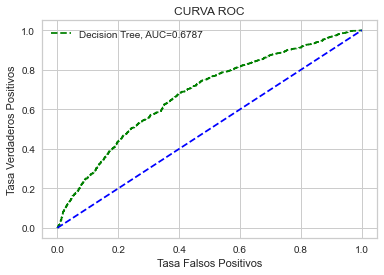

In [110]:
utils.curva_roc(y=y_train,modelo=Modelo,X=X_train)

Modelo AUC: 0.6875983033315272


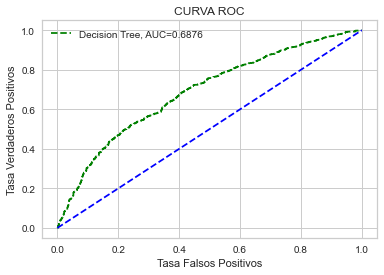

In [111]:
utils.curva_roc(y=y_train,modelo=xgb_model ,X=X_train)

Accuracy: 0.6116666666666667
              precision    recall  f1-score   support

           0       0.46      0.66      0.54      1049
           1       0.76      0.59      0.66      1951

    accuracy                           0.61      3000
   macro avg       0.61      0.62      0.60      3000
weighted avg       0.66      0.61      0.62      3000



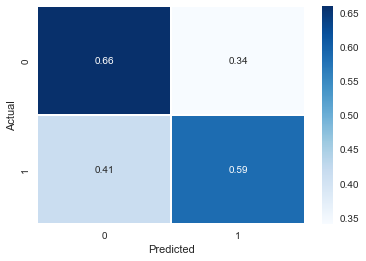

In [112]:
utils.MetricasMatrixConfusion(y=y_train,modelo=Modelo,X=X_train)

Accuracy: 0.616
              precision    recall  f1-score   support

           0       0.47      0.66      0.55      1049
           1       0.76      0.59      0.67      1951

    accuracy                           0.62      3000
   macro avg       0.61      0.63      0.61      3000
weighted avg       0.66      0.62      0.62      3000



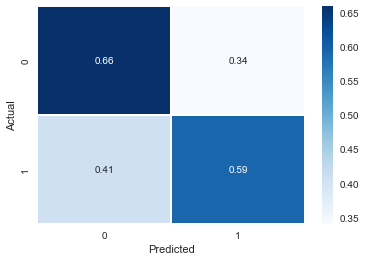

In [113]:
utils.MetricasMatrixConfusion(y=y_train,modelo=xgb_model ,X=X_train)

Modelo AUC: 0.6979166666666666


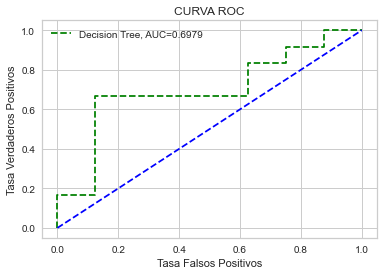

In [114]:
utils.curva_roc(y=y_test,modelo=Modelo,X=X_test)

Modelo AUC: 0.6875


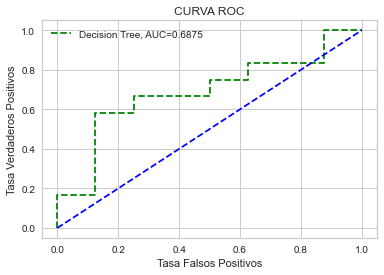

In [115]:
utils.curva_roc(y=y_test,modelo=xgb_model,X=X_test)

Accuracy: 0.7
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       0.80      0.67      0.73        12

    accuracy                           0.70        20
   macro avg       0.70      0.71      0.70        20
weighted avg       0.72      0.70      0.70        20



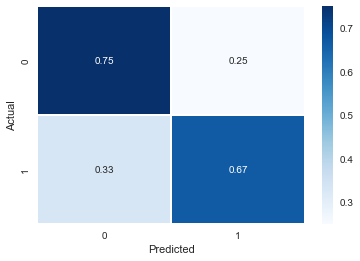

In [116]:
utils.MetricasMatrixConfusion(y=y_test,modelo=Modelo,X=X_test)

Accuracy: 0.7
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         8
           1       0.80      0.67      0.73        12

    accuracy                           0.70        20
   macro avg       0.70      0.71      0.70        20
weighted avg       0.72      0.70      0.70        20



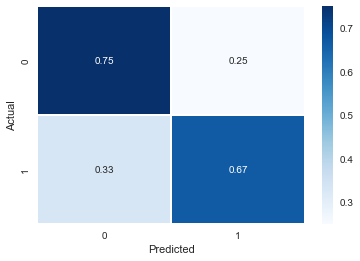

In [117]:
utils.MetricasMatrixConfusion(y=y_test,modelo=xgb_model,X=X_test)

In [118]:
Predicciones_Test = Modelo.predict(X_test)
Probabilidades_Test =Modelo.predict_proba(X_test)


In [119]:
Predicciones_Test1 = xgb_model.predict(X_test)
Probabilidades_Test1 =xgb_model.predict_proba(X_test)

In [120]:
ResultadoTEST=utils.Resultados(test,Predicciones_Test,Probabilidades_Test)
ResultadoTEST

,date,team_x,opponent_x,gf,ga,Probabilidad_x,Probabilidad_y,EquipoGanador,PrediccionFinal,Target,ResultadoFinal,PreditFinal1,Validacion
0,2023-11-20,Sampaio Correa,Avai,4.000,0.000,0.636,0.392,Sampaio Correa,1.000,1.000,W,0.244,Acerto
1,2023-11-19,Guarani,ABC,2.000,3.000,0.664,0.384,Guarani,1.000,0.000,L,0.280,NoAcerto
2,2023-11-19,CRB,Tombense Futebol Clube,2.000,0.000,0.642,0.378,CRB,1.000,1.000,W,0.264,Acerto
3,2023-11-18,Criciuma,Botafogo SP,3.000,0.000,0.678,0.372,Criciuma,1.000,1.000,W,0.305,Acerto
4,2023-11-18,Vitoria,Sport Recife,1.000,0.000,0.676,0.386,Vitoria,1.000,1.000,W,0.290,Acerto
5,2023-11-18,Vila Nova,Ceara,3.000,1.000,0.641,0.394,Vila Nova,1.000,1.000,W,0.247,Acerto
6,2023-11-18,Juventude,Ponte Preta,0.000,0.000,0.633,0.387,Juventude,1.000,1.000,D,0.246,Acerto
7,2023-11-18,Mirassol Futebol Clube,Atletico Goianiense,4.000,1.000,0.611,0.397,Mirassol Futebol Clube,1.000,1.000,W,0.215,Acerto
8,2023-11-17,Ituano,Chapecoense,0.000,0.000,0.611,0.387,Ituano,1.000,1.000,D,0.223,Acerto
9,2023-11-17,Londrina,Gremio Novorizontino,0.000,1.000,0.604,0.374,Londrina,1.000,0.000,L,0.230,NoAcerto


In [121]:
Val=pd.DataFrame(pd.crosstab(ResultadoTEST['date'], ResultadoTEST['Validacion']))
Val

Validacion,Acerto,NoAcerto
date,,
2023-11-17,1,1
2023-11-18,5,0
2023-11-19,1,1
2023-11-20,1,0


In [122]:
ResultadoTEST.Validacion.value_counts(normalize=True)

Acerto     0.800
NoAcerto   0.200
Name: Validacion, dtype: float64

In [123]:
ResultadoTEST.Validacion.value_counts()

Acerto      8
NoAcerto    2
Name: Validacion, dtype: int64

In [124]:
ResultadoTEST[ResultadoTEST.Validacion=="NoAcerto"]

,date,team_x,opponent_x,gf,ga,Probabilidad_x,Probabilidad_y,EquipoGanador,PrediccionFinal,Target,ResultadoFinal,PreditFinal1,Validacion
1,2023-11-19,Guarani,ABC,2.000,3.000,0.664,0.384,Guarani,1.000,0.000,L,0.280,NoAcerto
9,2023-11-17,Londrina,Gremio Novorizontino,0.000,1.000,0.604,0.374,Londrina,1.000,0.000,L,0.230,NoAcerto


In [125]:
ResultadoTEST.sort_values("date",ascending=False)

,date,team_x,opponent_x,gf,ga,Probabilidad_x,Probabilidad_y,EquipoGanador,PrediccionFinal,Target,ResultadoFinal,PreditFinal1,Validacion
0,2023-11-20,Sampaio Correa,Avai,4.000,0.000,0.636,0.392,Sampaio Correa,1.000,1.000,W,0.244,Acerto
1,2023-11-19,Guarani,ABC,2.000,3.000,0.664,0.384,Guarani,1.000,0.000,L,0.280,NoAcerto
2,2023-11-19,CRB,Tombense Futebol Clube,2.000,0.000,0.642,0.378,CRB,1.000,1.000,W,0.264,Acerto
3,2023-11-18,Criciuma,Botafogo SP,3.000,0.000,0.678,0.372,Criciuma,1.000,1.000,W,0.305,Acerto
4,2023-11-18,Vitoria,Sport Recife,1.000,0.000,0.676,0.386,Vitoria,1.000,1.000,W,0.290,Acerto
5,2023-11-18,Vila Nova,Ceara,3.000,1.000,0.641,0.394,Vila Nova,1.000,1.000,W,0.247,Acerto
6,2023-11-18,Juventude,Ponte Preta,0.000,0.000,0.633,0.387,Juventude,1.000,1.000,D,0.246,Acerto
7,2023-11-18,Mirassol Futebol Clube,Atletico Goianiense,4.000,1.000,0.611,0.397,Mirassol Futebol Clube,1.000,1.000,W,0.215,Acerto
8,2023-11-17,Ituano,Chapecoense,0.000,0.000,0.611,0.387,Ituano,1.000,1.000,D,0.223,Acerto
9,2023-11-17,Londrina,Gremio Novorizontino,0.000,1.000,0.604,0.374,Londrina,1.000,0.000,L,0.230,NoAcerto


In [126]:
ResultadoTEST1=utils.Resultados(test,Predicciones_Test1,Probabilidades_Test1)
ResultadoTEST1

,date,team_x,opponent_x,gf,ga,Probabilidad_x,Probabilidad_y,EquipoGanador,PrediccionFinal,Target,ResultadoFinal,PreditFinal1,Validacion
0,2023-11-20,Sampaio Correa,Avai,4.000,0.000,0.622,0.385,Sampaio Correa,1.000,1.000,W,0.237,Acerto
1,2023-11-19,Guarani,ABC,2.000,3.000,0.652,0.379,Guarani,1.000,0.000,L,0.273,NoAcerto
2,2023-11-19,CRB,Tombense Futebol Clube,2.000,0.000,0.640,0.383,CRB,1.000,1.000,W,0.257,Acerto
3,2023-11-18,Vila Nova,Ceara,3.000,1.000,0.661,0.386,Vila Nova,1.000,1.000,W,0.275,Acerto
4,2023-11-18,Criciuma,Botafogo SP,3.000,0.000,0.642,0.377,Criciuma,1.000,1.000,W,0.266,Acerto
5,2023-11-18,Vitoria,Sport Recife,1.000,0.000,0.642,0.383,Vitoria,1.000,1.000,W,0.259,Acerto
6,2023-11-18,Juventude,Ponte Preta,0.000,0.000,0.636,0.382,Juventude,1.000,1.000,D,0.254,Acerto
7,2023-11-18,Mirassol Futebol Clube,Atletico Goianiense,4.000,1.000,0.634,0.389,Mirassol Futebol Clube,1.000,1.000,W,0.245,Acerto
8,2023-11-17,Ituano,Chapecoense,0.000,0.000,0.654,0.384,Ituano,1.000,1.000,D,0.270,Acerto
9,2023-11-17,Londrina,Gremio Novorizontino,0.000,1.000,0.629,0.385,Londrina,1.000,0.000,L,0.243,NoAcerto


In [127]:
Val1=pd.DataFrame(pd.crosstab(ResultadoTEST1['date'], ResultadoTEST1['Validacion']))
Val1

Validacion,Acerto,NoAcerto
date,,
2023-11-17,1,1
2023-11-18,5,0
2023-11-19,1,1
2023-11-20,1,0


In [128]:
ResultadoTEST1.Validacion.value_counts(normalize=True)

Acerto     0.800
NoAcerto   0.200
Name: Validacion, dtype: float64

# **Predicciones Nuevas**

In [129]:
#stop

In [130]:
X=BaseModelos[FEATURES]

In [131]:
Modelo.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=2, max_features=0.7524769932672861,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=3.3119195164198194e-09,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=265,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [132]:
xgb_model.fit(X, y)

ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=2, max_features=0.7524769932672861,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=3.3119195164198194e-09,
                     min_samples_leaf=4, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=265, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

In [133]:
BaseModelos1=pd.concat([Total2[["date","target","result","team","opponent","gf","ga"]],X_Numericas_standard1,datos_dummies1],axis=1).reset_index(drop=True)
BaseModelos1.tail()

,date,target,result,team,opponent,gf,ga,round,day,season,...,Local2_SinResultado,Local3_Away,Local3_Home,Local3_SinResultado,Local4_Away,Local4_Home,Local4_SinResultado,Local5_Away,Local5_Home,Local5_SinResultado
15,2023-11-25,NaN,NaN,Criciuma,Gremio Novorizontino,NaN,NaN,0.000,0.000,0.000,...,0,0,1,0,0,1,0,0,1,0
16,2023-11-25,NaN,NaN,Ceara,Juventude,NaN,NaN,0.000,0.000,0.000,...,0,1,0,0,1,0,0,1,0,0
17,2023-11-25,NaN,NaN,Mirassol Futebol Clube,Tombense Futebol Clube,NaN,NaN,0.000,0.000,0.000,...,0,0,1,0,0,1,0,0,1,0
18,2023-11-25,NaN,NaN,Atletico Goianiense,Guarani,NaN,NaN,0.000,0.000,0.000,...,0,1,0,0,1,0,0,1,0,0
19,2023-11-25,NaN,NaN,ABC,Vila Nova,NaN,NaN,0.000,0.000,0.000,...,0,1,0,0,1,0,0,1,0,0


In [134]:
nueva=BaseModelos1[FEATURES]

In [135]:
nueva.shape

(20, 160)

In [136]:
X_train.shape

(3000, 160)

In [137]:
Probabilidades_New =Modelo.predict_proba(nueva)
Predicciones_New  = Modelo.predict(nueva)
Probabilidades_New1 =xgb_model.predict_proba(nueva)
Predicciones_New1 = xgb_model.predict(nueva)

In [138]:
ResultadoRF=utils.Resultados(BaseModelos1,Predicciones_New,Probabilidades_New)
ResultadoRF

,date,team_x,opponent_x,gf,ga,Probabilidad_x,Probabilidad_y,EquipoGanador,PrediccionFinal,Target,ResultadoFinal,PreditFinal1,Validacion
0,2023-11-25,Sport Recife,Sampaio Correa,NaN,NaN,0.688,0.390,Sport Recife,1.000,NaN,NaN,0.298,NoAcerto
1,2023-11-25,Chapecoense,Vitoria,NaN,NaN,0.665,0.407,Chapecoense,1.000,NaN,NaN,0.259,NoAcerto
2,2023-11-25,Ponte Preta,CRB,NaN,NaN,0.625,0.390,Ponte Preta,1.000,NaN,NaN,0.235,NoAcerto
3,2023-11-25,Gremio Novorizontino,Criciuma,NaN,NaN,0.610,0.406,Gremio Novorizontino,1.000,NaN,NaN,0.205,NoAcerto
4,2023-11-25,Tombense Futebol Clube,Mirassol Futebol Clube,NaN,NaN,0.606,0.372,Tombense Futebol Clube,1.000,NaN,NaN,0.234,NoAcerto
5,2023-11-25,Atletico Goianiense,Guarani,NaN,NaN,0.603,0.380,Atletico Goianiense,1.000,NaN,NaN,0.223,NoAcerto
6,2023-11-25,Avai,Ituano,NaN,NaN,0.600,0.373,Avai,1.000,NaN,NaN,0.227,NoAcerto
7,2023-11-25,Ceara,Juventude,NaN,NaN,0.594,0.388,Ceara,1.000,NaN,NaN,0.206,NoAcerto
8,2023-11-25,Botafogo SP,Londrina,NaN,NaN,0.588,0.366,Botafogo SP,1.000,NaN,NaN,0.222,NoAcerto
9,2023-11-25,ABC,Vila Nova,NaN,NaN,0.514,0.411,ABC,1.000,NaN,NaN,0.103,NoAcerto


In [139]:
ResultadoRF.sort_values("date",ascending=True)

,date,team_x,opponent_x,gf,ga,Probabilidad_x,Probabilidad_y,EquipoGanador,PrediccionFinal,Target,ResultadoFinal,PreditFinal1,Validacion
0,2023-11-25,Sport Recife,Sampaio Correa,NaN,NaN,0.688,0.390,Sport Recife,1.000,NaN,NaN,0.298,NoAcerto
1,2023-11-25,Chapecoense,Vitoria,NaN,NaN,0.665,0.407,Chapecoense,1.000,NaN,NaN,0.259,NoAcerto
2,2023-11-25,Ponte Preta,CRB,NaN,NaN,0.625,0.390,Ponte Preta,1.000,NaN,NaN,0.235,NoAcerto
3,2023-11-25,Gremio Novorizontino,Criciuma,NaN,NaN,0.610,0.406,Gremio Novorizontino,1.000,NaN,NaN,0.205,NoAcerto
4,2023-11-25,Tombense Futebol Clube,Mirassol Futebol Clube,NaN,NaN,0.606,0.372,Tombense Futebol Clube,1.000,NaN,NaN,0.234,NoAcerto
5,2023-11-25,Atletico Goianiense,Guarani,NaN,NaN,0.603,0.380,Atletico Goianiense,1.000,NaN,NaN,0.223,NoAcerto
6,2023-11-25,Avai,Ituano,NaN,NaN,0.600,0.373,Avai,1.000,NaN,NaN,0.227,NoAcerto
7,2023-11-25,Ceara,Juventude,NaN,NaN,0.594,0.388,Ceara,1.000,NaN,NaN,0.206,NoAcerto
8,2023-11-25,Botafogo SP,Londrina,NaN,NaN,0.588,0.366,Botafogo SP,1.000,NaN,NaN,0.222,NoAcerto
9,2023-11-25,ABC,Vila Nova,NaN,NaN,0.514,0.411,ABC,1.000,NaN,NaN,0.103,NoAcerto


In [140]:
ResultadoRF["Model"]="modelo1"
ResultadoRF["Liga"]=Liga
ResultadoRF["Temporada"]=Temporada
seleccion=["Temporada","date","Liga","Model","team_x","opponent_x","Probabilidad_x","Probabilidad_y","EquipoGanador"]
ResultadoRF=ResultadoRF[seleccion]

In [141]:
ResultadoRF.sort_values("date",ascending=True).to_excel("Pronosticos/Brasil_B_Pronosticos_RF"+FechaFinalTest+".xlsx",index=False)
ResultadoRF

,Temporada,date,Liga,Model,team_x,opponent_x,Probabilidad_x,Probabilidad_y,EquipoGanador
0,2023,2023-11-25,Brasil B,modelo1,Sport Recife,Sampaio Correa,0.688,0.390,Sport Recife
1,2023,2023-11-25,Brasil B,modelo1,Chapecoense,Vitoria,0.665,0.407,Chapecoense
2,2023,2023-11-25,Brasil B,modelo1,Ponte Preta,CRB,0.625,0.390,Ponte Preta
3,2023,2023-11-25,Brasil B,modelo1,Gremio Novorizontino,Criciuma,0.610,0.406,Gremio Novorizontino
4,2023,2023-11-25,Brasil B,modelo1,Tombense Futebol Clube,Mirassol Futebol Clube,0.606,0.372,Tombense Futebol Clube
5,2023,2023-11-25,Brasil B,modelo1,Atletico Goianiense,Guarani,0.603,0.380,Atletico Goianiense
6,2023,2023-11-25,Brasil B,modelo1,Avai,Ituano,0.600,0.373,Avai
7,2023,2023-11-25,Brasil B,modelo1,Ceara,Juventude,0.594,0.388,Ceara
8,2023,2023-11-25,Brasil B,modelo1,Botafogo SP,Londrina,0.588,0.366,Botafogo SP
9,2023,2023-11-25,Brasil B,modelo1,ABC,Vila Nova,0.514,0.411,ABC


In [142]:
ResultadoRF1=utils.Resultados(BaseModelos1,Predicciones_New1,Probabilidades_New1)

In [143]:
#ResultadoRF1.sort_values("date",ascending=True)

In [144]:
ResultadoRF1["Model"]="modelo2"
ResultadoRF1["Liga"]=Liga
ResultadoRF1["Temporada"]=Temporada
ResultadoRF1=ResultadoRF1[seleccion]

In [145]:
ResultadoRF1.sort_values("date",ascending=True).to_excel("Pronosticos/Brasil_BPronosticos_XGB"+FechaFinalTest+".xlsx",index=False)
ResultadoRF1

,Temporada,date,Liga,Model,team_x,opponent_x,Probabilidad_x,Probabilidad_y,EquipoGanador
0,2023,2023-11-25,Brasil B,modelo2,Sport Recife,Sampaio Correa,0.646,0.370,Sport Recife
1,2023,2023-11-25,Brasil B,modelo2,Chapecoense,Vitoria,0.636,0.389,Chapecoense
2,2023,2023-11-25,Brasil B,modelo2,Gremio Novorizontino,Criciuma,0.633,0.388,Gremio Novorizontino
3,2023,2023-11-25,Brasil B,modelo2,Atletico Goianiense,Guarani,0.632,0.384,Atletico Goianiense
4,2023,2023-11-25,Brasil B,modelo2,Tombense Futebol Clube,Mirassol Futebol Clube,0.631,0.385,Tombense Futebol Clube
5,2023,2023-11-25,Brasil B,modelo2,Avai,Ituano,0.630,0.385,Avai
6,2023,2023-11-25,Brasil B,modelo2,Ponte Preta,CRB,0.629,0.378,Ponte Preta
7,2023,2023-11-25,Brasil B,modelo2,Ceara,Juventude,0.626,0.384,Ceara
8,2023,2023-11-25,Brasil B,modelo2,Botafogo SP,Londrina,0.607,0.382,Botafogo SP
9,2023,2023-11-25,Brasil B,modelo2,ABC,Vila Nova,0.599,0.442,ABC


## **Red Neuronal**

In [146]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Codificación de etiquetas
encoder = LabelEncoder()
y_test = encoder.fit_transform(y_test)
y_train = encoder.fit_transform(y_train)

# Normalización de datos
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

# Definición del modelo
model = Sequential()
model.add(Dense(207, input_dim=X_train.shape[1], activation='relu')) # Capa de entrada
model.add(Dropout(0.2)) # Capa de Dropout
model.add(Dense(150, activation='relu')) # Capa oculta
model.add(Dropout(0.2)) # Capa de Dropout
model.add(Dense(100, activation='relu')) # Capa oculta
model.add(Dropout(0.2)) # Capa de Dropout
model.add(Dense(80, activation='relu')) # Capa oculta
model.add(Dropout(0.2)) # Capa de Dropout
model.add(Dense(32, activation='relu')) # Capa oculta
model.add(Dropout(0.2)) # Capa de Dropout
model.add(Dense(16, activation='relu')) # Capa oculta
model.add(Dropout(0.2)) # Capa de Dropout
model.add(Dense(1, activation='sigmoid')) # Capa de salida

# Compilación del modelo
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['AUC'])

# Parada temprana para prevenir el sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Entrenamiento del modelo
model.fit(X_train, y_train, validation_split=0.2, epochs=500, batch_size=32, callbacks=[early_stopping])

# Evaluación del modelo
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))


Epoch 1/500


2023-11-25 00:23:12.023532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


75/75 [==============================] - 1s 5ms/step - loss: 0.6621 - auc: 0.5125 - val_loss: 0.6171 - val_auc: 0.6651
Epoch 2/500
75/75 [==============================] - 0s 2ms/step - loss: 0.6468 - auc: 0.5724 - val_loss: 0.6010 - val_auc: 0.6776
Epoch 3/500
75/75 [==============================] - 0s 2ms/step - loss: 0.6387 - auc: 0.5962 - val_loss: 0.6007 - val_auc: 0.6576
Epoch 4/500
75/75 [==============================] - 0s 2ms/step - loss: 0.6290 - auc: 0.6319 - val_loss: 0.5956 - val_auc: 0.6772
Epoch 5/500
75/75 [==============================] - 0s 2ms/step - loss: 0.6159 - auc: 0.6668 - val_loss: 0.6012 - val_auc: 0.6666
Epoch 6/500
75/75 [==============================] - 0s 2ms/step - loss: 0.6014 - auc: 0.6917 - val_loss: 0.6171 - val_auc: 0.6574
Epoch 7/500
75/75 [==============================] - 0s 2ms/step - loss: 0.5897 - auc: 0.7085 - val_loss: 0.6469 - val_auc: 0.5754
Epoch 8/500
75/75 [==============================] - 0s 2ms/step - loss: 0.5620 - auc: 0.7493 -

In [147]:
# Genera las probabilidades
y_prob = model.predict(nueva)

# Generar las probabilidades de la clase positiva
y_prob_pos = model.predict(nueva)

# Calcular las probabilidades de la clase negativa
y_prob_neg = 1 - y_prob_pos

# Concatenar las dos matrices para obtener el formato deseado
y_prob = np.hstack((y_prob_neg, y_prob_pos))
# Genera las predicciones de clase
y_pred = (model.predict(nueva) > 0.5).astype(int)

# Si necesitas aplanar el array a una dimensión (dependiendo de la versión de TensorFlow puede devolver un array 2D)
y_pred = y_pred.flatten()
ResultadoRF3=utils.Resultados(BaseModelos1,y_pred,y_prob)
ResultadoRF3.sort_values("date",ascending=True)

1/1 [==============================] - 0s 14ms/step


,date,team_x,opponent_x,gf,ga,Probabilidad_x,Probabilidad_y,EquipoGanador,PrediccionFinal,Target,ResultadoFinal,PreditFinal1,Validacion
0,2023-11-25,Chapecoense,Vitoria,NaN,NaN,1.000,0.381,Chapecoense,1.000,NaN,NaN,0.618,NoAcerto
1,2023-11-25,Vila Nova,ABC,NaN,NaN,0.985,0.358,Vila Nova,1.000,NaN,NaN,0.627,NoAcerto
2,2023-11-25,CRB,Ponte Preta,NaN,NaN,0.901,0.564,CRB,1.000,NaN,NaN,0.336,NoAcerto
3,2023-11-25,Sport Recife,Sampaio Correa,NaN,NaN,0.893,0.662,Sport Recife,1.000,NaN,NaN,0.231,NoAcerto
4,2023-11-25,Atletico Goianiense,Guarani,NaN,NaN,0.852,0.226,Atletico Goianiense,1.000,NaN,NaN,0.626,NoAcerto
5,2023-11-25,Gremio Novorizontino,Criciuma,NaN,NaN,0.684,0.668,Gremio Novorizontino,1.000,NaN,NaN,0.016,NoAcerto
6,2023-11-25,Avai,Ituano,NaN,NaN,0.590,0.315,Avai,1.000,NaN,NaN,0.274,NoAcerto
7,2023-11-25,Juventude,Ceara,NaN,NaN,0.441,0.090,Juventude,0.000,NaN,NaN,0.351,NoAcerto
8,2023-11-25,Londrina,Botafogo SP,NaN,NaN,0.406,0.379,Londrina,0.000,NaN,NaN,0.026,NoAcerto
9,2023-11-25,Mirassol Futebol Clube,Tombense Futebol Clube,NaN,NaN,0.364,0.229,Mirassol Futebol Clube,0.000,NaN,NaN,0.136,NoAcerto


In [148]:
ResultadoRF3["Model"]="modelo3"
ResultadoRF3["Liga"]=Liga
ResultadoRF3["Temporada"]=Temporada
ResultadoRF3=ResultadoRF3[seleccion]

In [149]:

ResultadoRF3.sort_values("date",ascending=True).to_excel("Pronosticos/Brasil_BPronosticos_RedNeuronal"+FechaFinalTest+".xlsx",index=False)

In [150]:
ResultadoRF3

,Temporada,date,Liga,Model,team_x,opponent_x,Probabilidad_x,Probabilidad_y,EquipoGanador
0,2023,2023-11-25,Brasil B,modelo3,Chapecoense,Vitoria,1.000,0.381,Chapecoense
1,2023,2023-11-25,Brasil B,modelo3,Vila Nova,ABC,0.985,0.358,Vila Nova
2,2023,2023-11-25,Brasil B,modelo3,CRB,Ponte Preta,0.901,0.564,CRB
3,2023,2023-11-25,Brasil B,modelo3,Sport Recife,Sampaio Correa,0.893,0.662,Sport Recife
4,2023,2023-11-25,Brasil B,modelo3,Atletico Goianiense,Guarani,0.852,0.226,Atletico Goianiense
5,2023,2023-11-25,Brasil B,modelo3,Gremio Novorizontino,Criciuma,0.684,0.668,Gremio Novorizontino
6,2023,2023-11-25,Brasil B,modelo3,Avai,Ituano,0.590,0.315,Avai
7,2023,2023-11-25,Brasil B,modelo3,Juventude,Ceara,0.441,0.090,Juventude
8,2023,2023-11-25,Brasil B,modelo3,Londrina,Botafogo SP,0.406,0.379,Londrina
9,2023,2023-11-25,Brasil B,modelo3,Mirassol Futebol Clube,Tombense Futebol Clube,0.364,0.229,Mirassol Futebol Clube
